In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import matplotlib as mpl
output_dir="output"
import os

from perdiver.distances import *
import perdiver.perdiver as perdiver

plots_path = "plots/illustration/"
os.makedirs(plots_path, exist_ok=True)

EXECUTABLE_PATH: /home/atorras/repositories/navground-blofun/IBloFunMatch/build/IBloFunMatch


In [2]:
from navground import sim, core

number = 10
yaml = f"""
steps: 10000
time_step: 0.1
save_directory: ''
record_pose: true
record_twist: true
scenario:
  type: Cross
  agent_margin: 0.2
  side: 28
  target_margin: 0.6
  tolerance: 0.4
  groups:  
    -
      type: thymio
      number: {number}
      control_period: 0.1
      behavior:
        type: HL
        safety_margin: 0.25 
        horizon: 3
        barrier_angle: 1
      radius: 0.25
      kinematics:
        type: 2WDiff
        max_speed: 1.0
        wheel_axis: 2
      state_estimation:
        type: Bounded
        range: 2.0 
"""
experiment = sim.load_experiment(yaml)
experiment.run()

In [3]:
run = experiment.runs[0]
ps = run.poses[:,:,[0,1]]
twists = run.twists[:,:,:2] # ignore angular speeds

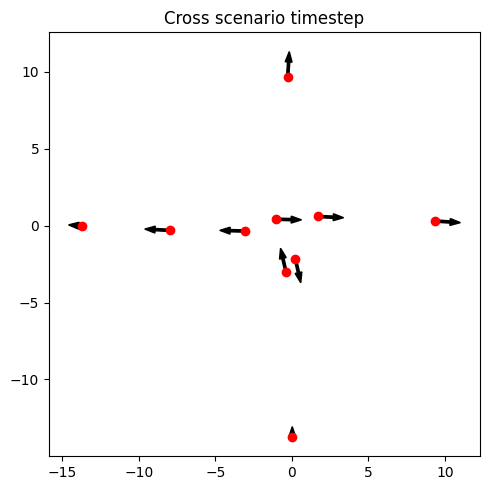

In [4]:
step = 400
fig, ax = plt.subplots(figsize=(5,5))
X = ps[step]
vec_X = twists[step]
ax.scatter(X[:,0], X[:,1], color="red", zorder=2)
for base, vel in zip(X, vec_X):
    ax.arrow(base[0], base[1], vel[0], vel[1], color="black", zorder=1, width=0.15)

ax.set_title("Cross scenario timestep")
plt.tight_layout()
plt.savefig(plots_path + "timestep_cross.png")

Next, we compute the distance matrix at the timestep.

In [29]:
weight=1
dist_result = perdiver.distances_weighted_velocities(X, vec_X, weight)

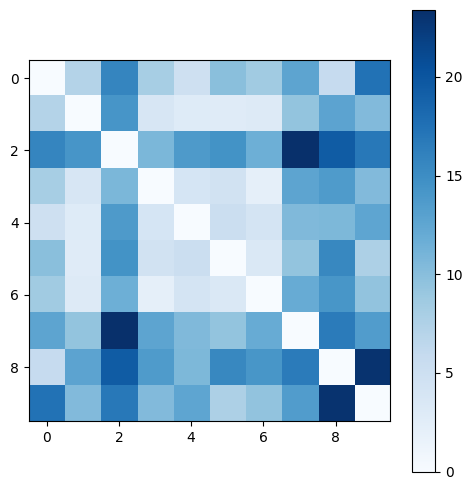

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(dist_result, cmap="Blues")
norm = mpl.colors.Normalize(np.min(dist_result), vmax=np.max(dist_result))
cmap = mpl.colormaps["Blues"]
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable=mappable, ax=ax)
plt.tight_layout()
plt.savefig(plots_path + "distance_matrix.png")

Let us compute Persistent homology using IBloFunMatch

In [31]:
import iblofunmatch.inter as ibfm
output_dir = "output"

In [32]:
idx_S = list(range(dist_result.shape[0]))
ibfm_out = ibfm.get_IBloFunMatch_subset(dist_result, dist_result, idx_S, output_dir, max_rad=-1, num_it=1, store_0_pm=True, points=False, max_dim=1)

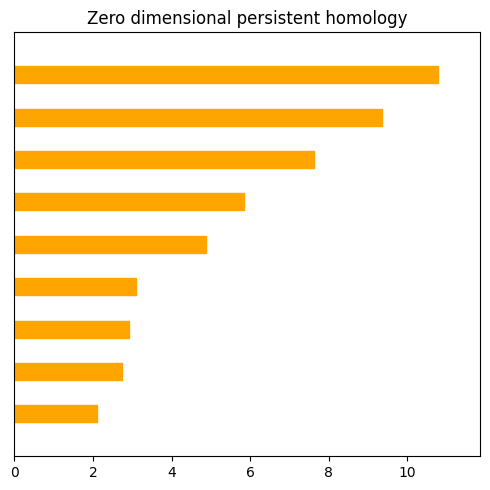

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
ibfm.plot_barcode(ibfm_out["X_barcode_0"], "orange", ax)
ax.set_title("Zero dimensional persistent homology")
plt.tight_layout()
plt.savefig(plots_path + "PH0_cross.png")

Put together all clusters with distance less or equal to $10$

In [34]:
np.sum(ibfm_out["X_barcode_0"][:,1]<10)

8

In [35]:
ibfm_out["X_reps_0"]

[[3, 6], [1, 5], [1, 4], [1, 3], [0, 1], [0, 8], [5, 9], [1, 7], [1, 2]]

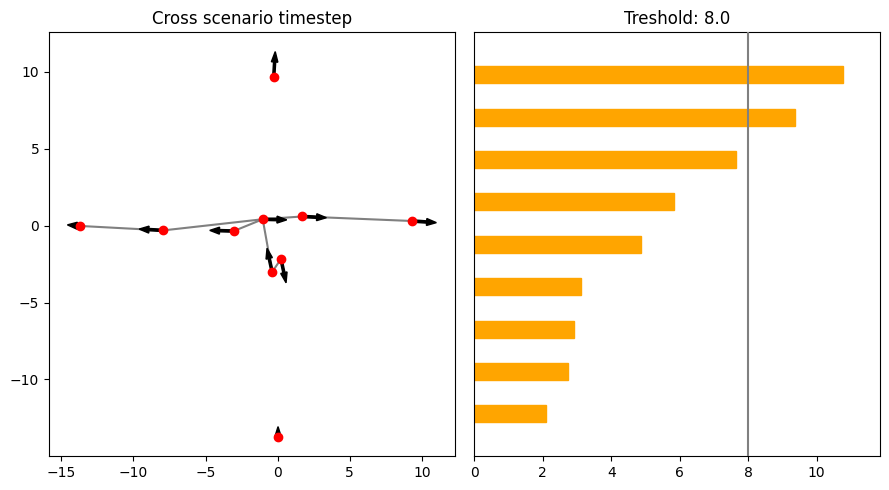

In [43]:
fig, ax = plt.subplots(ncols=2, figsize=(9,5))
ax[0].scatter(X[:,0], X[:,1], color="red", zorder=2)
for base, vel in zip(X, vec_X):
    ax[0].arrow(base[0], base[1], vel[0], vel[1], color="black", zorder=1, width=0.15)

treshold = 8
num_merged = np.sum(ibfm_out["X_barcode_0"][:,1]<treshold)
for i in range(num_merged):
    edge = X[ibfm_out["X_reps_0"][i]]
    ax[0].plot(edge[:,0], edge[:,1], color="gray", zorder=0.1)
    
ax[0].set_title("Cross scenario timestep")

# Plot diagram with vertical line 
ibfm.plot_barcode(ibfm_out["X_barcode_0"], "orange", ax[1])
num_bars = len(ibfm_out["X_barcode_0"])
ax[1].plot([treshold, treshold], [-2, num_bars], c="gray", zorder=3)
ax[1].set_title(f"Treshold: {treshold:.1f}")
plt.tight_layout()
plt.savefig(plots_path + "clusters_cross.png")